Processing Sequences Using RNNs 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys


import time

In [2]:
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf
from tensorflow import keras

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.__version__

'2.7.0'

# PART A: Many-to-One

### Generate the Dataset

In [5]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [7]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [8]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [9]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

### --- PART A  ###

In [10]:
np.random.seed(361)

n_steps = 50
ndata = 1000
series = generate_time_series(ndata, n_steps + 1)

n1 = int(ndata*0.7)
n2 = int(ndata*0.9)

X_train, y_train = series[:n1, :n_steps], series[:n1, -1]
X_valid, y_valid = series[n1:n2, :n_steps], series[n1:n2, -1]
X_test, y_test = series[n2:, :n_steps], series[n2:, -1]

In [11]:
print(X_train.shape,y_train.shape)

(700, 50, 1) (700, 1)


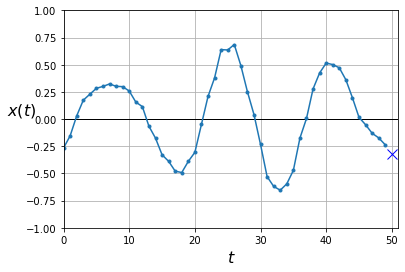

In [12]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_label=("$x(t)$" ))
plt.show()

In [13]:
X_valid[0,0]
y_valid[0, 0]

-0.31715655

 ## A1: Naive predictions (just predict the last observed value):

In [14]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020681996

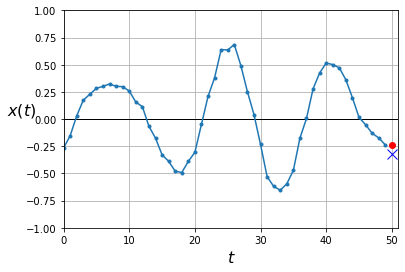

In [15]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [16]:
X_valid[0,:,0].shape

(50,)

### A2:  Linear predictions

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

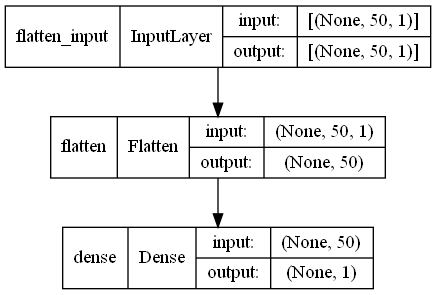

In [19]:
plot_model(model, './log/fig10_a2.png', show_shapes=True)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
model.evaluate(X_valid, y_valid)

Epoch 1/20
22/22 [==============================] - 1s 15ms/step - loss: 0.1913 - val_loss: 0.1666
Epoch 2/20
22/22 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1310
Epoch 3/20
22/22 [==============================] - 0s 9ms/step - loss: 0.1133 - val_loss: 0.1077
Epoch 4/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0967 - val_loss: 0.0938
Epoch 5/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0852 - val_loss: 0.0840
Epoch 6/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0766 - val_loss: 0.0760
Epoch 7/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0694 - val_loss: 0.0689
Epoch 8/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0633 - val_loss: 0.0633
Epoch 9/20
22/22 [==============================] - 0s 9ms/step - loss: 0.0581 - val_loss: 0.0582
Epoch 10/20
22/22 [==============================] - 0s 8ms/step - loss: 0.0538 - val_loss: 0.0539
Epoch 11/20
22/22 

0.02724967524409294

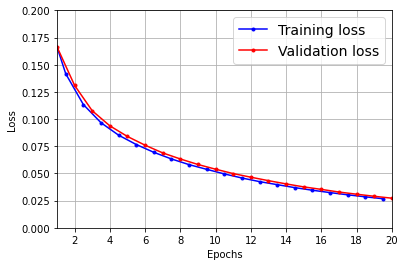

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

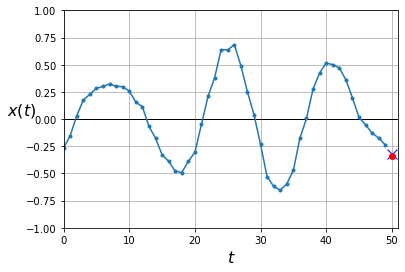

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## A3. Using a Simple RNN

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

In [25]:
m3 = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
m3.compile(loss="mse", optimizer=optimizer)
history = m3.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

C:\Python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
22/22 [==============================] - 4s 142ms/step - loss: 0.2404 - val_loss: 0.1958
Epoch 2/20
22/22 [==============================] - 3s 132ms/step - loss: 0.1523 - val_loss: 0.1282
Epoch 3/20
22/22 [==============================] - 3s 122ms/step - loss: 0.1005 - val_loss: 0.0948
Epoch 4/20
22/22 [==============================] - 3s 140ms/step - loss: 0.0793 - val_loss: 0.0824
Epoch 5/20
22/22 [==============================] - 3s 121ms/step - loss: 0.0706 - val_loss: 0.0746
Epoch 6/20
22/22 [==============================] - 3s 128ms/step - loss: 0.0638 - val_loss: 0.0678
Epoch 7/20
22/22 [==============================] - 3s 122ms/step - loss: 0.0583 - val_loss: 0.0620
Epoch 8/20
22/22 [==============================] - 3s 130ms/step - loss: 0.0535 - val_loss: 0.0572
Epoch 9/20
22/22 [==============================] - 3s 130ms/step - loss: 0.0493 - val_loss: 0.0530
Epoch 10/20
22/22 [==============================] - 3s 140ms/step - loss: 0.0459 - val_loss: 0.0495

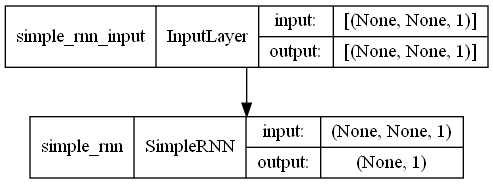

In [26]:
model = m3
plot_model(model, '../log/fig10_a3.png', show_shapes=True)

In [27]:
m3.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 19ms/step - loss: 0.0305


0.03049168363213539

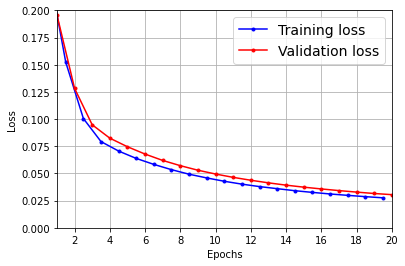

In [28]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

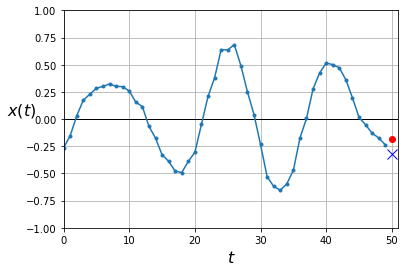

In [29]:
y_pred = m3.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [30]:
m3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## A4. Deep RNNs

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
m4 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

m4.compile(loss="mse", optimizer="adam")
history = m4.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 11s 418ms/step - loss: 0.2681 - val_loss: 0.0901
Epoch 2/20
22/22 [==============================] - 9s 394ms/step - loss: 0.0781 - val_loss: 0.0420
Epoch 3/20
22/22 [==============================] - 9s 417ms/step - loss: 0.0353 - val_loss: 0.0257
Epoch 4/20
22/22 [==============================] - 9s 402ms/step - loss: 0.0252 - val_loss: 0.0187
Epoch 5/20
22/22 [==============================] - 10s 435ms/step - loss: 0.0180 - val_loss: 0.0159
Epoch 6/20
22/22 [==============================] - 9s 422ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 7/20
22/22 [==============================] - 9s 418ms/step - loss: 0.0131 - val_loss: 0.0123
Epoch 8/20
22/22 [==============================] - 9s 418ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 9/20
22/22 [==============================] - 9s 406ms/step - loss: 0.0104 - val_loss: 0.0111
Epoch 10/20
22/22 [==============================] - 10s 434ms/step - loss: 0.0090 - val_loss: 0.0

In [33]:
m4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 1)                 22        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


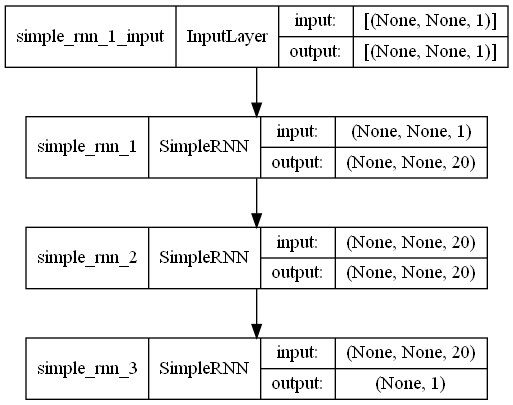

In [34]:
model = m4
plot_model(model, '../log/fig10_a4.png', show_shapes=True)

In [35]:
m4.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 64ms/step - loss: 0.0058


0.005848660599440336

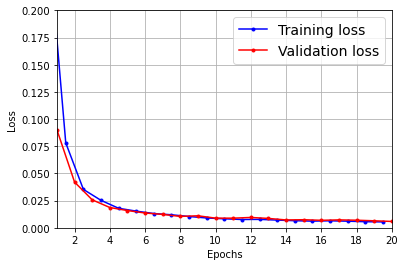

In [36]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

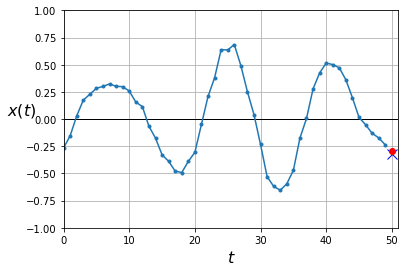

In [37]:
y_pred = m4.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## A5. Deep RNNs with retrun only the last output

Make the second `SimpleRNN` layer return only the last output:

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

In [39]:
m5 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

m5.compile(loss="mse", optimizer="adam")
history = m5.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 8s 290ms/step - loss: 0.1061 - val_loss: 0.0616
Epoch 2/20
22/22 [==============================] - 6s 274ms/step - loss: 0.0461 - val_loss: 0.0301
Epoch 3/20
22/22 [==============================] - 6s 279ms/step - loss: 0.0234 - val_loss: 0.0167
Epoch 4/20
22/22 [==============================] - 6s 276ms/step - loss: 0.0150 - val_loss: 0.0121
Epoch 5/20
22/22 [==============================] - 6s 292ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 6/20
22/22 [==============================] - 6s 280ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 7/20
22/22 [==============================] - 6s 273ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/20
22/22 [==============================] - 6s 280ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 9/20
22/22 [==============================] - 6s 278ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 10/20
22/22 [==============================] - 6s 283ms/step - loss: 0.0054 - val_loss: 0.0054

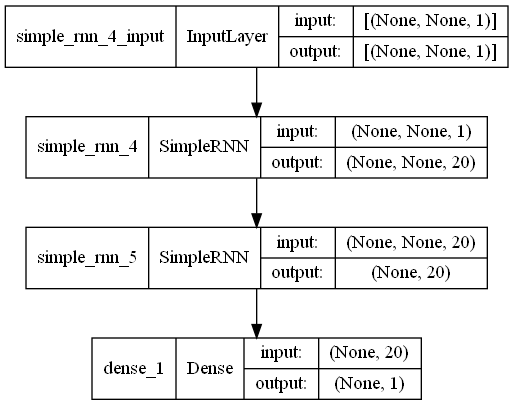

In [40]:
model = m5
plot_model(model, '../log/fig10_a5.png', show_shapes=True)

In [41]:
m5.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 39ms/step - loss: 0.0041


0.004081796854734421

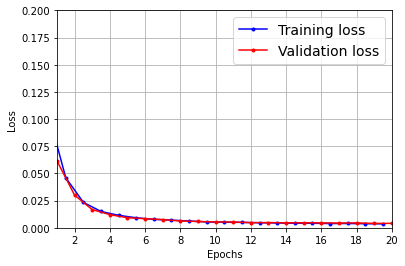

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

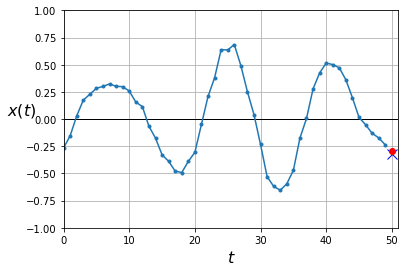

In [43]:
y_pred = m5.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [44]:
m5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


# PART B: Many-to-Many 
- keras.layers.TimeDistributed
- Forecasting Several Steps Ahead

## Many-to-many data preparation

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [45]:
np.random.seed(42)

n_steps = 50
n_forward = 10 
ndata = 2000
n1 = int(ndata*0.7)
n2 = int(ndata*0.9)

series = generate_time_series(ndata, n_steps + n_forward )
X_train = series[:n1, :n_steps]
X_valid = series[n1:n2, :n_steps]
X_test = series[n2:, :n_steps]
y = np.empty((ndata, n_steps, n_forward ))

for step_ahead in range(1, n_forward  + 1):
    y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
y_train = y[:n1]
y_valid = y[n1:n2]
y_test = y[n2:]

In [46]:
X_train.shape, y_train.shape

((1400, 50, 1), (1400, 50, 10))

## B1. Simple RNN

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_forward))
])

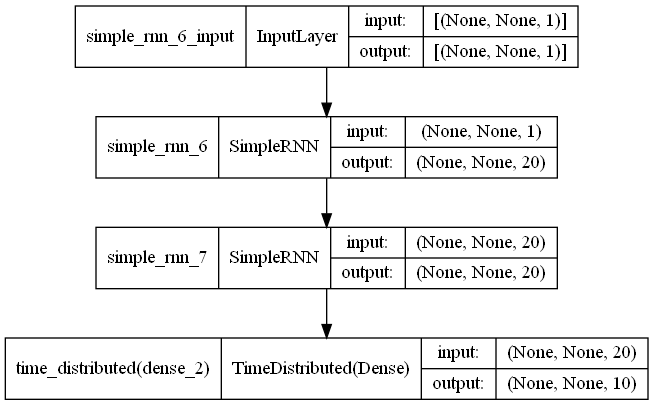

In [48]:
plot_model(model, './log/fig10_b1.png', show_shapes=True)

In [49]:
#!pip install pydot

In [50]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

C:\Python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
44/44 [==============================] - 13s 274ms/step - loss: 0.0737 - last_time_step_mse: 0.0667 - val_loss: 0.0464 - val_last_time_step_mse: 0.0362
Epoch 2/20
44/44 [==============================] - 12s 268ms/step - loss: 0.0462 - last_time_step_mse: 0.0361 - val_loss: 0.0437 - val_last_time_step_mse: 0.0317
Epoch 3/20
44/44 [==============================] - 12s 267ms/step - loss: 0.0449 - last_time_step_mse: 0.0346 - val_loss: 0.0429 - val_last_time_step_mse: 0.0345
Epoch 4/20
44/44 [==============================] - 12s 272ms/step - loss: 0.0431 - last_time_step_mse: 0.0326 - val_loss: 0.0421 - val_last_time_step_mse: 0.0302
Epoch 5/20
44/44 [==============================] - 12s 269ms/step - loss: 0.0420 - last_time_step_mse: 0.0323 - val_loss: 0.0403 - val_last_time_step_mse: 0.0305
Epoch 6/20
44/44 [==============================] - 12s 278ms/step - loss: 0.0412 - last_time_step_mse: 0.0322 - val_loss: 0.0398 - val_last_time_step_mse: 0.0311
Epoch 7/20
44/44 [====

In [51]:
b1 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many simpleRNN model', b1)

The loss of Many-to-Many simpleRNN model 0.028265805914998055


In [52]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

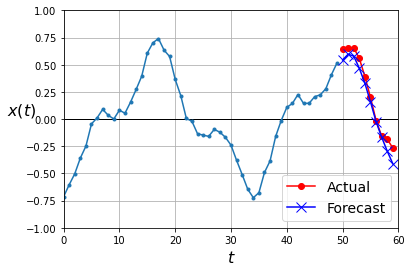

In [53]:
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

## B2. Deep RNN with Batch Norm

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

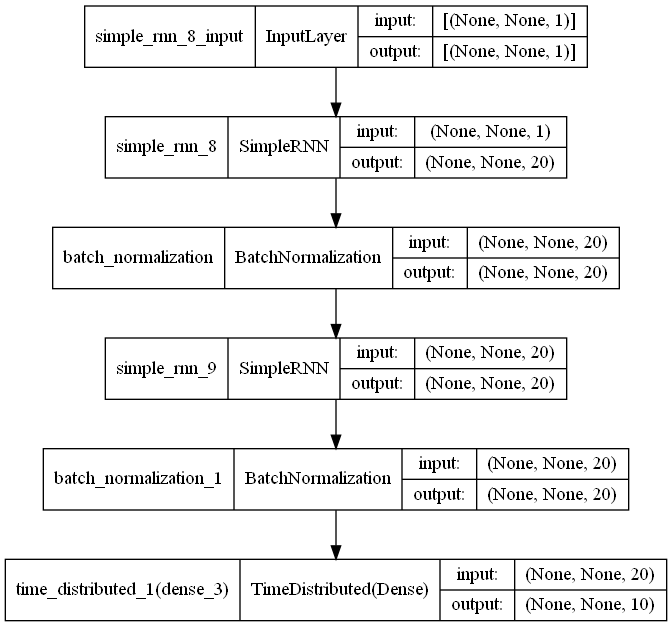

In [55]:
plot_model(model, '../log/fig10_b2.png', show_shapes=True)

In [57]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
44/44 [==============================] - 14s 275ms/step - loss: 0.6503 - last_time_step_mse: 0.6645 - val_loss: 0.1618 - val_last_time_step_mse: 0.1587
Epoch 2/20
44/44 [==============================] - 11s 259ms/step - loss: 0.1160 - last_time_step_mse: 0.1063 - val_loss: 0.1252 - val_last_time_step_mse: 0.1198
Epoch 3/20
44/44 [==============================] - 11s 261ms/step - loss: 0.0772 - last_time_step_mse: 0.0679 - val_loss: 0.1067 - val_last_time_step_mse: 0.1012
Epoch 4/20
44/44 [==============================] - 11s 261ms/step - loss: 0.0665 - last_time_step_mse: 0.0573 - val_loss: 0.0970 - val_last_time_step_mse: 0.0925
Epoch 5/20
44/44 [==============================] - 12s 272ms/step - loss: 0.0609 - last_time_step_mse: 0.0525 - val_loss: 0.0904 - val_last_time_step_mse: 0.0871
Epoch 6/20
44/44 [==============================] - 12s 272ms/step - loss: 0.0572 - last_time_step_mse: 0.0490 - val_loss: 0.0803 - val_last_time_step_mse: 0.0760
Epoch 7/20
44/44 [====

In [58]:
b2 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many DeepRNN model', b2)

The loss of Many-to-Many DeepRNN model 0.042562227696180344


## B3. LSTMs

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

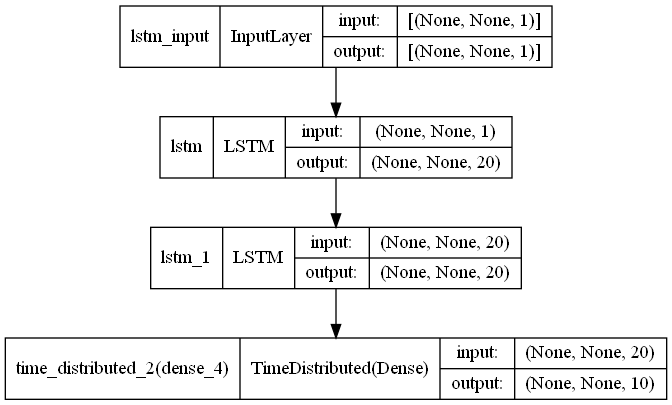

In [60]:
plot_model(model, '../log/fig10_b3.png', show_shapes=True)

In [61]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
44/44 [==============================] - 7s 49ms/step - loss: 0.1165 - last_time_step_mse: 0.1100 - val_loss: 0.0893 - val_last_time_step_mse: 0.0759
Epoch 2/20
44/44 [==============================] - 1s 31ms/step - loss: 0.0806 - last_time_step_mse: 0.0666 - val_loss: 0.0721 - val_last_time_step_mse: 0.0555
Epoch 3/20
44/44 [==============================] - 1s 30ms/step - loss: 0.0679 - last_time_step_mse: 0.0516 - val_loss: 0.0628 - val_last_time_step_mse: 0.0469
Epoch 4/20
44/44 [==============================] - 1s 30ms/step - loss: 0.0607 - last_time_step_mse: 0.0427 - val_loss: 0.0582 - val_last_time_step_mse: 0.0376
Epoch 5/20
44/44 [==============================] - 1s 29ms/step - loss: 0.0564 - last_time_step_mse: 0.0374 - val_loss: 0.0543 - val_last_time_step_mse: 0.0330
Epoch 6/20
44/44 [==============================] - 1s 30ms/step - loss: 0.0526 - last_time_step_mse: 0.0324 - val_loss: 0.0506 - val_last_time_step_mse: 0.0281
Epoch 7/20
44/44 [================

In [62]:
b3 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many LSTM model', b3)

The loss of Many-to-Many LSTM model 0.03354961425065994


In [63]:
model.evaluate(X_valid, y_valid)

13/13 [==============================] - 0s 7ms/step - loss: 0.0337 - last_time_step_mse: 0.0140


[0.03371847793459892, 0.014027809724211693]

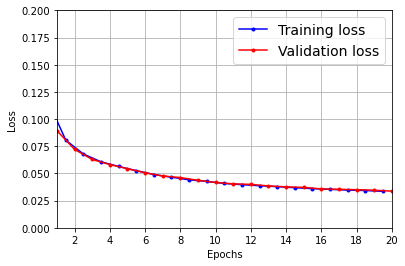

In [64]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [65]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

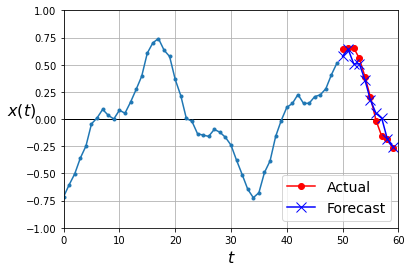

In [66]:
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

## B4. GRUs

In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

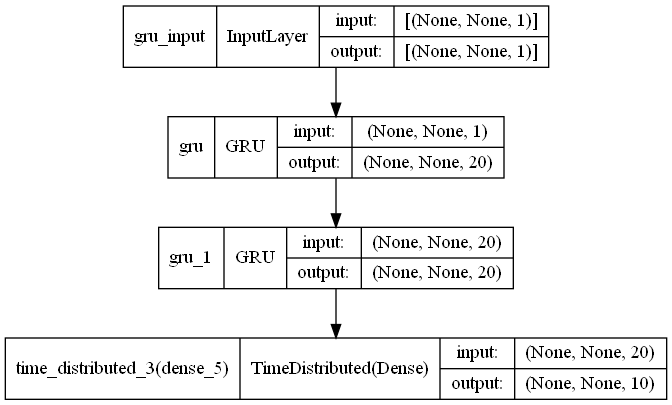

In [68]:
plot_model(model, '../log/fig10_b4.png', show_shapes=True)

In [69]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
44/44 [==============================] - 5s 33ms/step - loss: 0.1245 - last_time_step_mse: 0.1211 - val_loss: 0.0936 - val_last_time_step_mse: 0.0876
Epoch 2/20
44/44 [==============================] - 1s 14ms/step - loss: 0.0750 - last_time_step_mse: 0.0698 - val_loss: 0.0642 - val_last_time_step_mse: 0.0560
Epoch 3/20
44/44 [==============================] - 1s 16ms/step - loss: 0.0622 - last_time_step_mse: 0.0536 - val_loss: 0.0583 - val_last_time_step_mse: 0.0473
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.0574 - last_time_step_mse: 0.0473 - val_loss: 0.0546 - val_last_time_step_mse: 0.0426
Epoch 5/20
44/44 [==============================] - 1s 18ms/step - loss: 0.0541 - last_time_step_mse: 0.0433 - val_loss: 0.0522 - val_last_time_step_mse: 0.0409
Epoch 6/20
44/44 [==============================] - 1s 18ms/step - loss: 0.0514 - last_time_step_mse: 0.0408 - val_loss: 0.0494 - val_last_time_step_mse: 0.0367
Epoch 7/20
44/44 [================

In [70]:
b4 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many GRU model', b4)

The loss of Many-to-Many GRU model 0.03667585179209709


In [71]:
model.evaluate(X_valid, y_valid)

13/13 [==============================] - 0s 6ms/step - loss: 0.0359 - last_time_step_mse: 0.0259


[0.03587906062602997, 0.025916578248143196]

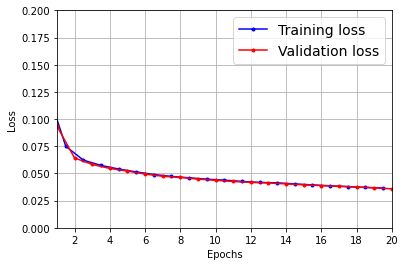

In [72]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [73]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

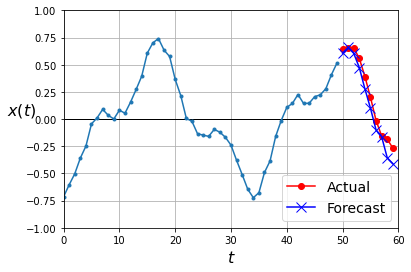

In [74]:
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

## B5. 1D-CNN 

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [75]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

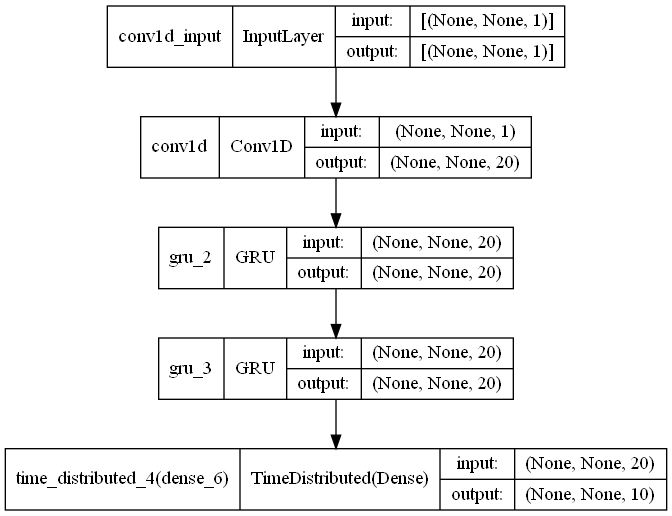

In [76]:
plot_model(model, '../log/fig10_b5.png', show_shapes=True)

In [77]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, y_valid[:, 3::2]))

Epoch 1/20
44/44 [==============================] - 7s 37ms/step - loss: 0.1126 - last_time_step_mse: 0.1091 - val_loss: 0.0818 - val_last_time_step_mse: 0.0732
Epoch 2/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0680 - last_time_step_mse: 0.0597 - val_loss: 0.0606 - val_last_time_step_mse: 0.0502
Epoch 3/20
44/44 [==============================] - 1s 14ms/step - loss: 0.0586 - last_time_step_mse: 0.0493 - val_loss: 0.0559 - val_last_time_step_mse: 0.0457
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.0545 - last_time_step_mse: 0.0461 - val_loss: 0.0521 - val_last_time_step_mse: 0.0425
Epoch 5/20
44/44 [==============================] - 1s 16ms/step - loss: 0.0505 - last_time_step_mse: 0.0428 - val_loss: 0.0482 - val_last_time_step_mse: 0.0385
Epoch 6/20
44/44 [==============================] - 1s 19ms/step - loss: 0.0465 - last_time_step_mse: 0.0392 - val_loss: 0.0443 - val_last_time_step_mse: 0.0353
Epoch 7/20
44/44 [================

In [78]:
b5 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many 1D-CNN model', b5)

The loss of Many-to-Many 1D-CNN model 0.02614729292690754


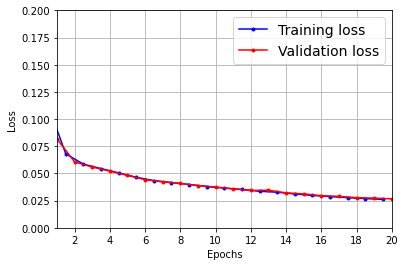

In [79]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

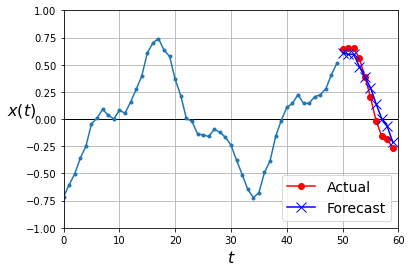

In [80]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

## B6. WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [81]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

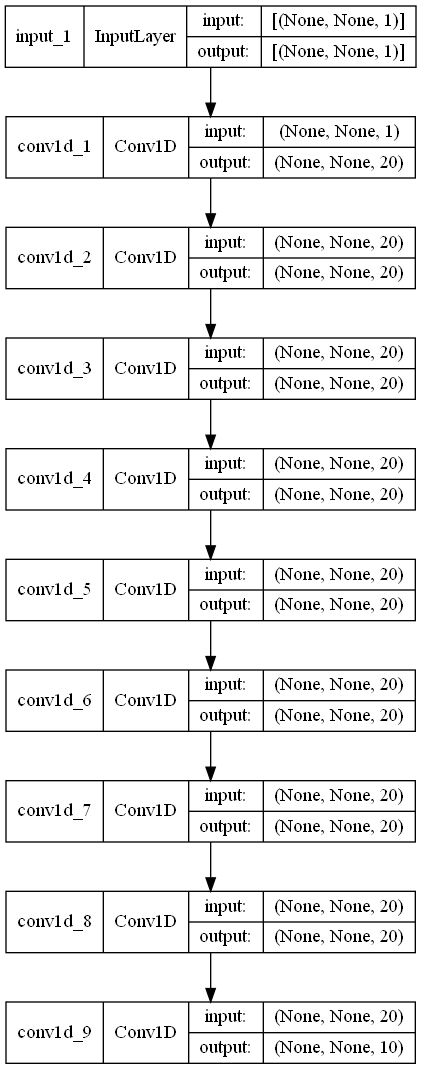

In [82]:
plot_model(model, 'fig10_b6.png', show_shapes=True)

In [83]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
44/44 [==============================] - 3s 39ms/step - loss: 0.1280 - last_time_step_mse: 0.1239 - val_loss: 0.0974 - val_last_time_step_mse: 0.0891
Epoch 2/20
44/44 [==============================] - 1s 28ms/step - loss: 0.0770 - last_time_step_mse: 0.0621 - val_loss: 0.0634 - val_last_time_step_mse: 0.0457
Epoch 3/20
44/44 [==============================] - 1s 29ms/step - loss: 0.0556 - last_time_step_mse: 0.0390 - val_loss: 0.0496 - val_last_time_step_mse: 0.0325
Epoch 4/20
44/44 [==============================] - 1s 28ms/step - loss: 0.0462 - last_time_step_mse: 0.0305 - val_loss: 0.0433 - val_last_time_step_mse: 0.0268
Epoch 5/20
44/44 [==============================] - 1s 27ms/step - loss: 0.0417 - last_time_step_mse: 0.0268 - val_loss: 0.0394 - val_last_time_step_mse: 0.0245
Epoch 6/20
44/44 [==============================] - 1s 26ms/step - loss: 0.0384 - last_time_step_mse: 0.0245 - val_loss: 0.0366 - val_last_time_step_mse: 0.0233
Epoch 7/20
44/44 [================

In [84]:
b6 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of Many-to-Many WaveNet model', b6)

The loss of Many-to-Many WaveNet model 0.02668020874261856


In [85]:
model.evaluate(X_valid, y_valid)

13/13 [==============================] - 0s 12ms/step - loss: 0.0268 - last_time_step_mse: 0.0155


[0.026762790977954865, 0.015490100719034672]

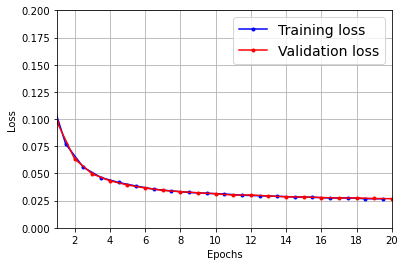

In [86]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

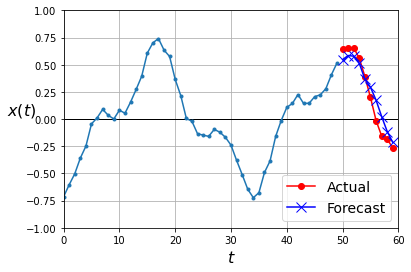

In [87]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, y_new = series[:, :50, :], series[:, 50:, :]
y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

plot_multiple_forecasts(X_new, y_new, y_pred)
plt.show()

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

# Results Summary of Many-to-Many : PART B

In [88]:
models = pd.DataFrame({
    'Model': ['SimpleRNN', 'DeepRNN',  'LSTM', 'GRU', '1D-CNN', 'WaveNet'],
    'Score': [b1, b2, b3, b4, b5, b6]})
models.sort_values(by='Score', ascending=True)

,Model,Score
4,1D-CNN,0.026147
5,WaveNet,0.026680
0,SimpleRNN,0.028266
2,LSTM,0.033550
3,GRU,0.036676
1,DeepRNN,0.042562
